In [1]:
import pandas as pd
import numpy as np
import shared
import json


In [2]:
ve_or_ju = "ve"

In [3]:
runs_orig = pd.read_csv(f'data/runs_{ve_or_ju}.tsv', delimiter="\t")


In [4]:
country_counts = runs_orig["team_country"].value_counts()
top_country_counts = country_counts[country_counts > 100]
top_countries = top_country_counts.keys().tolist()
display(top_countries)

with open(f"data/top_countries_{ve_or_ju}.json", 'w') as outfile:
    json.dump(top_countries, outfile)

['FIN', 'SWE', 'NOR', 'RUS', 'LAT', 'EST', 'SUI', 'GBR']

In [5]:
runs_orig["first_name"] = runs_orig.name.str.split(" ", expand=True).iloc[:, 0]
runs_df = runs_orig
runs_df.head()

,name,year,team_id,team,team_country,pace,leg_nro,num_runs,first_name
0,anna mårsell,2018,3,STORA TUNA OK,SWE,6.441,1,3,anna
1,anna mårsell,2017,7,STORA TUNA OK,SWE,7.214,1,3,anna
2,anna mårsell,2016,22,STORA TUNA OK,SWE,6.291,1,3,anna
3,magdalena olsson,2018,3,STORA TUNA OK,SWE,6.511,2,6,magdalena
4,magdalena olsson,2017,7,STORA TUNA OK,SWE,7.381,2,6,magdalena


In [6]:
fn_counts = runs_df["first_name"].value_counts()
top_fn_counts = fn_counts[fn_counts > 20]
top_first_names = top_fn_counts.keys().tolist()

with open(f"data/top_first_names_{ve_or_ju}.json", 'w') as outfile:
    json.dump(top_first_names, outfile)

In [7]:
# Temporarily remove 2018 in order to try predict it in other notebook
#runs_df = runs_df[runs_df.year != 2018]
#runs_df

In [8]:
features = shared.preprocess_features(runs_df, top_countries, ve_or_ju)
features.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35869 entries, 0 to 35868
Data columns (total 9 columns):
name            35869 non-null object
year            35869 non-null int64
team_id         35869 non-null int64
team            35869 non-null object
team_country    35652 non-null object
pace            35869 non-null float64
leg_nro         35869 non-null int64
num_runs        35869 non-null int64
first_name      35869 non-null object
dtypes: float64(1), int64(4), object(4)
memory usage: 2.5+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931 entries, 0 to 930
Data columns (total 3 columns):
first_name           930 non-null object
fn_pace_class        931 non-null int64
fn_pace_std_class    931 non-null int64
dtypes: int64(2), object(1)
memory usage: 21.9+ KB


None

[]

,team_id,team_id_log10,team_id_square,leg_1,leg_2,leg_3,leg_4,c_EST,c_FIN,c_GBR,...,fn_pace_class_6.0,fn_pace_class_7.0,fn_pace_class_8.0,fn_pace_class_9.0,fn_pace_class_nan,fn_pace_std_class_0.0,fn_pace_std_class_1.0,fn_pace_std_class_2.0,fn_pace_std_class_3.0,fn_pace_std_class_nan
0,3,0.477121,9,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,7,0.845098,49,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,22,1.342423,484,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,3,0.477121,9,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,7,0.845098,49,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
5,28,1.447158,784,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
6,32,1.505150,1024,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
7,27,1.431364,729,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
8,34,1.531479,1156,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
9,3,0.477121,9,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [9]:
features.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 35869 entries, 0 to 35868
Data columns (total 40 columns):
team_id                  35869 non-null Sparse[int64, nan]
team_id_log10            35869 non-null Sparse[float64, nan]
team_id_square           35869 non-null Sparse[int64, nan]
leg_1                    35869 non-null Sparse[uint8, 0]
leg_2                    35869 non-null Sparse[uint8, 0]
leg_3                    35869 non-null Sparse[uint8, 0]
leg_4                    35869 non-null Sparse[uint8, 0]
c_EST                    35869 non-null Sparse[uint8, 0]
c_FIN                    35869 non-null Sparse[uint8, 0]
c_GBR                    35869 non-null Sparse[uint8, 0]
c_LAT                    35869 non-null Sparse[uint8, 0]
c_NOR                    35869 non-null Sparse[uint8, 0]
c_OTHER                  35869 non-null Sparse[uint8, 0]
c_RUS                    35869 non-null Sparse[uint8, 0]
c_SUI                    35869 non-null Sparse[uint8, 0]
c_SWE          

In [10]:
x = features.values
#x = features[["team_id", "team_id_log10", "team_id_log100", "team_id_log2", "team_id_square", "leg_id_1", "leg_id_2", "leg_id_3", "leg_id_4", "leg_id_5", "leg_id_6", "leg_id_7"]].values # Poista tää.
y = np.log(runs_df.pace.values)
y = y.reshape(len(y), 1)

display(x.shape)
display(y.shape)

(35869, 40)

(35869, 1)

In [11]:
import sklearn
from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import joblib

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2019)
x_train.shape

(28695, 40)

In [13]:
import matplotlib.pyplot as plt
def fit_and_test_model(model, x_train, x_test, y_train, y_test, fit_params={}):
    model.fit(x_train, y_train.ravel(), **fit_params)
    y_pred = np.exp(model.predict(x_test))
    print(f"Shapes: y_test={np.exp(y_test).shape} y_pred={y_pred.shape}")
    print("Mean squared error: %.3f" % mean_squared_error(np.exp(y_test), y_pred))
    print('Explained variance score: %.3f' % r2_score(np.exp(y_test), y_pred))
    
    plt.scatter(x_test[:,0], np.exp(y_test),  color='red', alpha=0.01)
    plt.scatter(x_test[:,0], y_pred, color='blue', alpha=0.01)
    plt.ylim(4, 20)
    plt.show()

In [14]:
y_train.shape

(28695, 1)

Shapes: y_test=(7174, 1) y_pred=(7174,)
Mean squared error: 5.831
Explained variance score: 0.410


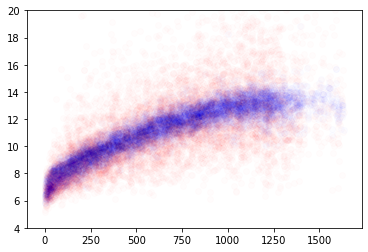

CPU times: user 909 ms, sys: 474 ms, total: 1.38 s
Wall time: 467 ms


In [15]:
%%time
linear = linear_model.LinearRegression()
fit_and_test_model(linear, x_train, x_test, y_train, y_test)

In [16]:
pd.DataFrame({'name':features.keys(), 'coef':linear.coef_})

,name,coef
0,team_id,6.350089e-04
1,team_id_log10,5.366650e-02
2,team_id_square,-2.483030e-07
3,leg_1,-4.363906e-02
4,leg_2,-3.186587e-03
5,leg_3,2.244853e-02
6,leg_4,2.437711e-02
7,c_EST,3.443986e-02
8,c_FIN,5.157342e-02
9,c_GBR,5.748120e-03


      Iter       Train Loss   Remaining Time 
         1           0.0635            5.15m
         2           0.0586            4.85m
         3           0.0546            4.71m
         4           0.0512            4.77m
         5           0.0485            4.77m
         6           0.0463            4.79m
         7           0.0445            4.78m
         8           0.0430            4.64m
         9           0.0418            4.55m
        10           0.0407            4.51m
        20           0.0360            4.46m
        30           0.0346            4.33m
        40           0.0340            4.24m
        50           0.0336            4.07m
        60           0.0334            3.87m
        70           0.0332            3.69m
        80           0.0330            3.58m
        90           0.0329            3.47m
       100           0.0328            3.47m
       200           0.0321            2.88m
       300           0.0316            2.66m
       40

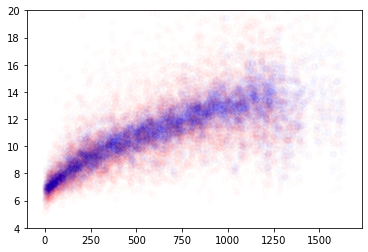

CPU times: user 3min 17s, sys: 632 ms, total: 3min 18s
Wall time: 3min 18s


In [17]:
%%time
gbr_num_estimators=7100
gbr = sklearn.ensemble.GradientBoostingRegressor(n_estimators=gbr_num_estimators, random_state=0, verbose=1)

fit_and_test_model(gbr, x_train, x_test, y_train, y_test)

#print(f"feature_importances_: {gbr.feature_importances_}")
#gbr_features = pd.DataFrame({'feature':first_names.columns, 'importance': gbr.feature_importances_})
#gbr_features['feature'] = gbr_features['feature'].str.replace('top_first_name_','')
#display(gbr_features.sort_values(by="importance", ascending=False))

In [18]:
gbr_num_estimators_quantile=int(gbr_num_estimators/2)

      Iter       Train Loss   Remaining Time 
         1           0.0594            2.22m
         2           0.0568            2.21m
         3           0.0546            2.13m
         4           0.0527            2.18m
         5           0.0511            2.24m
         6           0.0497            2.29m
         7           0.0484            2.35m
         8           0.0473            2.37m
         9           0.0464            2.34m
        10           0.0456            2.32m
        20           0.0422            2.20m
        30           0.0413            2.22m
        40           0.0408            2.24m
        50           0.0406            2.15m
        60           0.0405            2.08m
        70           0.0404            2.03m
        80           0.0403            1.97m
        90           0.0402            1.89m
       100           0.0401            1.85m
       200           0.0397            1.60m
       300           0.0395            1.50m
       40

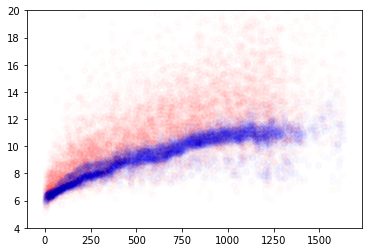

In [19]:
gbr_q_low = sklearn.ensemble.GradientBoostingRegressor(loss='quantile', alpha=0.159, n_estimators=gbr_num_estimators_quantile, random_state=0, verbose=1)
fit_and_test_model(gbr_q_low, x_train, x_test, y_train, y_test)


      Iter       Train Loss   Remaining Time 
         1           0.0628            2.52m
         2           0.0608            2.28m
         3           0.0591            2.18m
         4           0.0575            2.17m
         5           0.0562            2.26m
         6           0.0551            2.31m
         7           0.0541            2.35m
         8           0.0533            2.33m
         9           0.0525            2.29m
        10           0.0519            2.26m
        20           0.0484            2.07m
        30           0.0472            2.07m
        40           0.0465            1.92m
        50           0.0462            1.84m
        60           0.0460            1.78m
        70           0.0458            1.78m
        80           0.0456            1.73m
        90           0.0455            1.67m
       100           0.0455            1.63m
       200           0.0449            1.40m
       300           0.0448            1.23m
       40

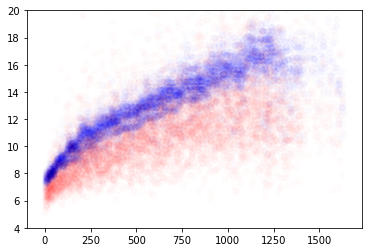

In [20]:
gbr_q_high = sklearn.ensemble.GradientBoostingRegressor(loss='quantile', alpha=0.841, n_estimators=gbr_num_estimators_quantile, random_state=0, verbose=1)
fit_and_test_model(gbr_q_high, x_train, x_test, y_train, y_test)



In [21]:
joblib.dump(gbr, f'gbr_{ve_or_ju}.sav')
joblib.dump(gbr_q_low, f'gbr_q_low_{ve_or_ju}.sav')
joblib.dump(gbr_q_high, f'gbr_q_high_{ve_or_ju}.sav')


['gbr_q_high_ve.sav']

In [22]:
gbr_preds = gbr.predict(pd.DataFrame(x_test))
gbr_q_low_preds = gbr_q_low.predict(pd.DataFrame(x_test))
gbr_q_high_preds = gbr_q_high.predict(pd.DataFrame(x_test))

In [23]:
gbr_q_pred_errors = pd.DataFrame({
    'q_low':np.exp(gbr_q_low_preds),
    'true':np.exp(y_test).ravel(), 
    'predicted':np.exp(gbr_preds), 
    'q_high':np.exp(gbr_q_high_preds), 
})

gbr_q_pred_errors["q_low_error"] = gbr_q_pred_errors.true < gbr_q_pred_errors.q_low
gbr_q_pred_errors["q_high_error"] = gbr_q_pred_errors.true > gbr_q_pred_errors.q_high
gbr_q_pred_errors["q_error"] = np.logical_or(gbr_q_pred_errors.q_low_error, gbr_q_pred_errors.q_high_error)

gbr_q_pred_errors["std"] = (gbr_q_pred_errors.q_high - gbr_q_pred_errors.q_low) / 2
# Intentionally don't use log scale for calculation to get bigger std 
gbr_q_pred_errors["std_correct"] = np.exp((gbr_q_high_preds - gbr_q_low_preds) / 2)
gbr_q_pred_errors["abs_error"] = np.abs(gbr_q_pred_errors.predicted - gbr_q_pred_errors.true)
gbr_q_pred_errors["abs_error_in_stds"] = gbr_q_pred_errors.abs_error / np.exp(gbr_q_pred_errors["std_correct"])

display(gbr_q_pred_errors.tail(15).round(3))
display(gbr_q_pred_errors.q_low_error.mean())
display(gbr_q_pred_errors.q_high_error.mean())
display(gbr_q_pred_errors.q_error.mean())
display(gbr_q_pred_errors["std"].mean())
display(gbr_q_pred_errors["std_correct"].mean())
display(gbr_q_pred_errors["abs_error_in_stds"].mean())

,q_low,true,predicted,q_high,q_low_error,q_high_error,q_error,std,std_correct,abs_error,abs_error_in_stds
7159,9.351,8.438,11.515,13.316,True,False,True,1.983,1.193,3.077,0.933
7160,10.500,13.588,12.932,16.510,False,False,False,3.005,1.254,0.656,0.187
7161,10.222,14.669,14.712,14.329,False,True,True,2.053,1.184,0.043,0.013
7162,8.704,11.358,10.664,12.172,False,False,False,1.734,1.183,0.694,0.213
7163,6.325,6.491,7.127,8.104,False,False,False,0.890,1.132,0.636,0.205
7164,10.616,13.706,12.561,16.303,False,False,False,2.844,1.239,1.145,0.332
7165,10.614,21.589,12.215,16.326,False,True,True,2.856,1.240,9.374,2.712
7166,10.540,14.208,13.488,17.247,False,False,False,3.354,1.279,0.720,0.200
7167,10.763,11.290,12.649,16.365,False,False,False,2.801,1.233,1.359,0.396
7168,13.107,12.068,13.172,18.176,True,False,True,2.535,1.178,1.104,0.340


0.1570950655143574

0.16573738500139393

0.3228324505157513

1.9732234117263427

1.1878727318479092

0.5050113906046731

In [24]:
np.exp(1.138)

3.1205210778255728

In [25]:
%%date

UsageError: Cell magic `%%date` not found.


In [ ]:
STOP_HERE

In [ ]:
import os
#os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'device=cpu'
#os.environ['THEANO_FLAGS'] = 'device=cuda,floatX=float32,force_device=True'

import pymc3 as pm
import pmlearn
from pmlearn.linear_model import LinearRegression
print('Running on pymc-learn v{}'.format(pmlearn.__version__))


In [ ]:
import multiprocessing
multiprocessing.cpu_count()

In [ ]:

pmlearn_linear = LinearRegression()
fit_params={
    "inference_type": "nuts",
    "inference_args": {
        "cores": multiprocessing.cpu_count() -1,
        #"chains":2,
        "init": 'adapt_diag',
        #"tune": 2000,
        "target_accept": 0.9999
    }
}
fit_and_test_model(pmlearn_linear, pd.DataFrame(data=x_train), pd.DataFrame(x_test), y_train, y_test,fit_params)

In [ ]:
pmlearn_preds = pmlearn_linear.predict(pd.DataFrame(x_test), return_std=True)

In [ ]:

joblib.dump(pmlearn_linear, 'pmlearn_linear.sav')

In [ ]:
pred_errors = pd.DataFrame({
    'mean':np.exp(pmlearn_preds[0]), 
    'std':np.exp(pmlearn_preds[1]), 
    'true':np.exp(y_test).ravel(), 
    'error':np.abs(np.exp(y_test).ravel() -np.exp(pmlearn_preds[0])) / np.exp(pmlearn_preds[1])
})
display(pred_errors.head(15))
pred_errors.error.mean()

In [ ]:
pmlearn_linear.plot_elbo()

In [ ]:
pm.traceplot(pmlearn_linear.trace)

In [ ]:
pm.forestplot(pmlearn_linear.trace, varnames=["betas", "alpha", "s"]);

In [ ]:
summary_df = pm.summary(pmlearn_linear.trace, varnames=["betas", "alpha", "s"])
summary_df

In [ ]:
pm.plot_posterior(pmlearn_linear.trace, varnames=["betas", "alpha", "s"],
                 figsize = [14, 8])

In [ ]:
pm.gelman_rubin(pmlearn_linear.trace, varnames=["betas", "alpha", "s"])